# GNN training for SIS dynamics on a BA network

## Including relevant packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import dynalearn as dl
import tqdm
from scipy.spatial.distance import jensenshannon
import tensorflow as tf
import pickle
import tensorflow.keras as ks
import tensorflow.keras.backend as K
import os
import getpass
from matplotlib.lines import Line2D

## Parameters and hyperparameters

In [2]:
path_to_dir = "/home/" + getpass.getuser() + "/Documents/ulaval/doctorat/projects/dynalearn/data/training/"
path_to_models = "/home/" + getpass.getuser() + "/Documents/ulaval/doctorat/projects/dynalearn/data/models/"
if os.path.exists("media/" + getpass.getuser() + "LaCie/"):
    path_to_dir = "media/" + getpass.getuser() + "LaCie/dynalearn-data/training/"
    path_to_models = "media/" + getpass.getuser() + "LaCie/dynalearn-data/models/"

    
    

param_dict = {
    "name": "sis-ba-100",
    "graph": {"name": "BAGraph", "params": {"N": 1000, "M": 2}},
    "dynamics": {
        "name": "SIS",
        "params": {"infection": 0.04, "recovery": 0.08, "init": "None"},
    },
    "model": {
        "name": "EpidemicPredictor",
        "config": dl.models.GNNConfig.SISGNN(),
    },
    "generator": {
        "name": "DynamicsGenerator",
        "config": dl.datasets.GeneratorConfig.default(),
        "sampler": {
            "name": "StateBiasedSampler",
            "config": dl.datasets.samplers.SamplerConfig.BiasedSamplerDefault(),
        },
    },
    "metrics": {
        "name": [
            "AttentionMetrics",
            "TrueLTPMetrics",
            "GNNLTPMetrics",
            "MLELTPMetrics",
            "TrueStarLTPMetrics",
            "GNNStarLTPMetrics",
            "UniformStarLTPMetrics",
            "StatisticsMetrics",
            "PoissonEpidemicsMFMetrics",
            "PoissonEpidemicsSSMetrics",
        ],
        "config": dl.metrics.MetricsConfig.test()
    },
    "training": dl.TrainingConfig.test(),
    "path_to_dir": path_to_dir,
    "path_to_bestmodel": path_to_models,
}



## Loading and running the experiment

In [3]:
experiment = dl.Experiment(param_dict)

In [4]:
experiment.run()

Generating data - 0.02089s:   4%|▍         | 4/100 [00:00<00:03, 28.18it/s]


---Generating data---


Generating data - 0.02491s: 100%|██████████| 100/100 [00:02<00:00, 36.08it/s]



---Training model---

Epoch 00001: LearningRateScheduler reducing learning rate to 0.0005000000237487257.
Epoch 1/5
1000/1000 [==============================] - 15s 15ms/step - loss: 0.4741 - model_entropy: 0.5712

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0005000000237487257.
Epoch 2/5
1000/1000 [==============================] - 18s 18ms/step - loss: 0.3362 - model_entropy: 0.3207

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0005000000237487257.
Epoch 3/5
1000/1000 [==============================] - 20s 20ms/step - loss: 0.3300 - model_entropy: 0.2783

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0005000000237487257.
Epoch 4/5
1000/1000 [==============================] - 16s 16ms/step - loss: 0.3278 - model_entropy: 0.2609

Epoch 00005: LearningRateScheduler reducing learning rate to 0.0005000000237487257.
Epoch 5/5
1000/1000 [==============================] - 16s 16ms/step - loss: 0.3288 - model_entropy: 0.2535


Computing AttentionMetrics:   0%|          | 0/100 [00:00<?, ?it/s]


---Computing metrics---


Computing PoissonEpidemicsMFMetrics: 100%|██████████| 80/80 [01:00<00:00,  2.43s/it]


invalid values for low thresholds: [-0.16828017534787765, -0.13104510621647902]
invalid values for high thresholds: [1, 1]


Computing PoissonEpidemicsSSMetrics: 100%|██████████| 400/400 [04:08<00:00,  1.02s/it]



---Saving all---


## Showing LTPs

/home/charles/Documents/ulaval/doctorat/projects/dynalearn/dynalearn/metrics/aggregator.py:61: RuntimeWarning: Mean of empty slice
  y[i] = op_val(values[index, out_state])
/home/charles/Documents/ulaval/doctorat/projects/dynalearn/dynalearn/metrics/aggregator.py:21: RuntimeWarning: Degrees of freedom <= 0 for slice.
  op_err = lambda xx: np.sqrt(np.nanvar(xx))


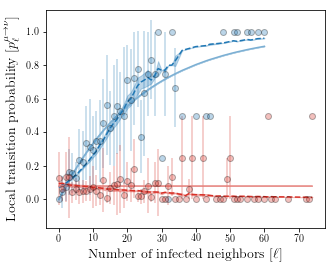

In [5]:
transitions = [(0, 1), (1, 0)]
transition_labels = [("S", "I"), ("I", "S")]
fontsize=14

color_true = [dl.utilities.color_pale["blue"], dl.utilities.color_pale["red"]]
color_gnn = [dl.utilities.color_dark["blue"], dl.utilities.color_dark["red"]]
handles = []

fig, ax = plt.subplots(1,1, figsize=(5, 4))
for i, t in enumerate(transitions):
    x, y, err = experiment.metrics["TrueLTPMetrics"].aggregate(experiment.metrics["TrueLTPMetrics"].data["ltp/train"],in_state=t[0], out_state=t[1])
    ax.fill_between(x, y - err, y + err, color=color_gnn[i], alpha=0.3)
    ax.plot(x, y, linestyle='-', color=color_true[i], label="True")
    
    x, y, err = experiment.metrics["GNNLTPMetrics"].aggregate(experiment.metrics["GNNLTPMetrics"].data["ltp/train"], in_state=t[0], out_state=t[1])
    ax.fill_between(x, y - err, y + err, color=color_gnn[i], alpha=0.3)
    ax.plot(x, y, linestyle='--', color=color_gnn[i], label="GNN")

    x, y, err = experiment.metrics["MLELTPMetrics"].aggregate(experiment.metrics["MLELTPMetrics"].data["ltp/train"], in_state=t[0], out_state=t[1])
    ax.errorbar(x, y, yerr=err, 
                linestyle='None', 
                marker='o', 
                color=color_gnn[i], 
                alpha=0.3, 
                markeredgewidth=1,
                markeredgecolor='k',
                label="MLE")
    
plt.xlabel(r"Number of infected neighbors $[\ell]$", fontsize=fontsize)
plt.ylabel(r"Local transition probability $[p^{\mu\to\nu}_\ell]$", fontsize=fontsize)
plt.show()

## Showing LTPs on star graphs

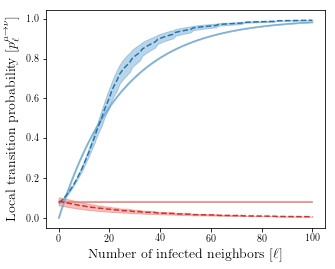

In [6]:
transitions = [(0, 1), (1, 0)]
transition_labels = [("S", "I"), ("I", "S")]
fontsize=14

color_true = [dl.utilities.color_pale["blue"], dl.utilities.color_pale["red"]]
color_gnn = [dl.utilities.color_dark["blue"], dl.utilities.color_dark["red"]]
handles = []

fig, ax = plt.subplots(1,1, figsize=(5, 4))
for i, t in enumerate(transitions):
    x, y, err = experiment.metrics["TrueStarLTPMetrics"].aggregate(experiment.metrics["TrueStarLTPMetrics"].data["ltp"],
                                                                   in_state=t[0], out_state=t[1])
    ax.fill_between(x, y - err, y + err, color=color_gnn[i], alpha=0.3)
    ax.plot(x, y, linestyle='-', color=color_true[i], label="True")
    
    x, y, err = experiment.metrics["GNNStarLTPMetrics"].aggregate(experiment.metrics["GNNStarLTPMetrics"].data["ltp"],
                                                                   in_state=t[0], out_state=t[1])
    ax.fill_between(x, y - err, y + err, color=color_gnn[i], alpha=0.3)
    ax.plot(x, y, linestyle='--', color=color_gnn[i], label="GNN")
    
#     x, y, err = experiment.metrics["UniformStarLTPMetrics"].aggregate(experiment.metrics["UniformStarLTPMetrics"].data["ltp"], 
#                                                                       in_state=t[0], out_state=t[1])
#     ax.fill_between(x, y - err, y + err, color=color_gnn[i], alpha=0.3)
#     ax.plot(x, y, linestyle='--', color=color_gnn[i], label="GNN")
    
    
plt.xlabel(r"Number of infected neighbors $[\ell]$", fontsize=fontsize)
plt.ylabel(r"Local transition probability $[p^{\mu\to\nu}_\ell]$", fontsize=fontsize)
plt.show()

## Showing JSD

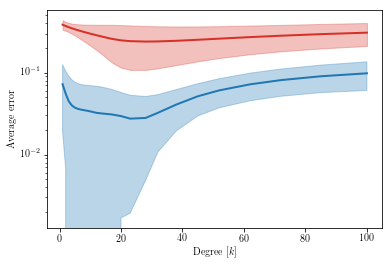

In [7]:
from scipy.spatial.distance import jensenshannon

jsd = experiment.metrics["TrueStarLTPMetrics"].compare("ltp", experiment.metrics["GNNStarLTPMetrics"], func=jensenshannon)
x, y, err = experiment.metrics["GNNStarLTPMetrics"].aggregate(jsd, for_degree=True)
plt.fill_between(x, y - err, y + err, color=dl.utilities.color_dark["blue"], alpha=0.3)
plt.plot(x, y, linestyle='-', color=dl.utilities.color_dark["blue"], linewidth=2)

jsd = experiment.metrics["TrueStarLTPMetrics"].compare("ltp", experiment.metrics["UniformStarLTPMetrics"], func=jensenshannon)
x, y, err = experiment.metrics["GNNStarLTPMetrics"].aggregate(jsd, for_degree=True)
plt.fill_between(x, y - err, y + err, color=dl.utilities.color_dark["red"], alpha=0.3)
plt.plot(x, y, linestyle='-', color=dl.utilities.color_dark["red"], linewidth=2)

plt.xlabel(r"Degree $[k]$")
plt.ylabel(r"Average error")

plt.xscale('linear')
plt.yscale('log')

plt.show()

## Showing Loss descent

In [8]:

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

e = np.arange(experiment.num_epochs)

ax[0].plot(e, experiment.history['loss'], 
        color=dl.utilities.color_dark["blue"], 
        marker="o", 
        markeredgewidth=1, 
        markeredgecolor="k",
        linestyle="-")

ax[0].plot(e, experiment.history['val_loss'], 
        color=dl.utilities.color_dark["red"], 
        marker="s", 
        markeredgewidth=1, 
        markeredgecolor="k",
        linestyle="-")



ax[1].plot(e, experiment.history["model_entropy"], 
        color=dl.utilities.color_dark["blue"], 
        marker="o", 
        markeredgewidth=1, 
        markeredgecolor="k",
        linestyle="-",
        label="Training")

ax[1].plot(e, experiment.history["val_model_entropy"], 
        color=dl.utilities.color_dark["red"], 
        marker="s", 
        markeredgewidth=1, 
        markeredgecolor="k",
        linestyle="-",
        label="Validation")

ax[0].set_xlabel(r'Epoch', fontsize=fontsize)
ax[0].set_ylabel(r'Loss', fontsize=fontsize)
ax[0].set_xlim([0, 19])
ax[0].set_ylim([0, 1])

ax[1].set_xlabel(r'Epoch', fontsize=fontsize)
ax[1].set_ylabel(r'Model entropy', fontsize=fontsize)
ax[1].set_xlim([0, 19])
ax[1].set_ylim([0, 1])
ax[1].legend(fontsize=fontsize)

plt.show()


KeyError: 'val_loss'

## Showing phase transition

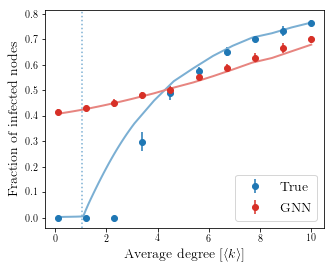

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))

ss_avgk = experiment.metrics["PoissonEpidemicsSSMetrics"].data["parameters"]
avg_s = experiment.metrics["PoissonEpidemicsSSMetrics"].data["true_low_avg"]
std_s = experiment.metrics["PoissonEpidemicsSSMetrics"].data["true_low_std"]
ax.errorbar(ss_avgk, 1 - avg_s[:,0], yerr=std_s[:,0], 
            color=dl.utilities.color_dark["blue"], 
            marker='o', 
            linestyle='None',
            label='True')

mf_avgk = experiment.metrics["PoissonEpidemicsMFMetrics"].data["parameters"]

mf_s = experiment.metrics["PoissonEpidemicsMFMetrics"].data["true_low_fp"]
threshold = experiment.metrics["PoissonEpidemicsMFMetrics"].data["true_thresholds"][0]
ax.plot(mf_avgk, 1 - mf_s[:, 0], linestyle='-', color=dl.utilities.color_pale["blue"], marker='None', linewidth=2)
ax.axvline(threshold, linestyle='dotted', color=dl.utilities.color_pale["blue"])

avg_s = experiment.metrics["PoissonEpidemicsSSMetrics"].data["gnn_low_avg"]
std_s = experiment.metrics["PoissonEpidemicsSSMetrics"].data["gnn_low_std"]
ax.errorbar(ss_avgk, 1 - avg_s[:,0], yerr=std_s[:,0], 
            color=dl.utilities.color_dark["red"], 
            marker='o', 
            linestyle='None',
            label='GNN')

mf_s = experiment.metrics["PoissonEpidemicsMFMetrics"].data["gnn_low_fp"]
# threshold = experiment.metrics["PoissonEpidemicsMFMetrics"].data["gnn_thresholds"][0]
ax.plot(mf_avgk, 1 - mf_s[:, 0], linestyle='-', color=dl.utilities.color_pale["red"], marker='None', linewidth=2)
# ax.axvline(threshold, linestyle='dotted', color=dl.utilities.color_pale["red"])

ax.set_xlabel(r"Average degree $[\langle k \rangle]$", fontsize=fontsize)
ax.set_ylabel(r"Fraction of infected nodes", fontsize=fontsize)
ax.legend(fontsize=fontsize)

plt.show()
